# AI輔助矽光子量子電路設計平台 - 演示筆記本

這個筆記本展示如何使用我們的平台進行矽光子量子電路設計和最佳化。

## 1. 環境設置和導入模組

In [1]:
import sys
import os
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 導入我們的模組
from core.components import DesignParameters, DirectionalCoupler, create_component
from core.simulator import CircuitSimulator, create_simple_circuit
from optimization.bayesian_opt import optimize_design
from optimization.surrogate_model import SurrogateModel
from evaluation.metrics import quick_evaluate

print("✅ 模組導入成功！")

✅ 模組導入成功！


## 2. 基礎元件測試

In [2]:
# 創建設計參數
params = DesignParameters(
    coupling_length=15.0,  # μm
    gap=0.2,              # μm
    waveguide_width=0.5,  # μm
    wavelength=1550e-9    # m
)

# 測試方向耦合器
coupler = DirectionalCoupler()
T = coupler.compute_transmission_matrix(params)
ratio = coupler.get_splitting_ratio(params)

print("方向耦合器測試:")
print(f"傳輸矩陣:\n{T}")
print(f"分束比: {ratio[0]:.3f} / {ratio[1]:.3f}")
print(f"總功率: {sum(ratio):.3f}")

方向耦合器測試:
傳輸矩陣:
[[0.94958831+0.j         0.        +0.31349966j]
 [0.        +0.31349966j 0.94958831+0.j        ]]
分束比: 0.902 / 0.098
總功率: 1.000


## 3. 電路模擬

In [3]:
# 創建簡單的分束器電路
simulator = create_simple_circuit(['directional_coupler'])
simulator.set_quantum_simulator(n_modes=2, n_photons=1)

# 執行模擬
result = simulator.simulate_classical(params)

print("電路模擬結果:")
print(f"傳輸效率: {result.transmission_efficiency:.3f}")
print(f"分束比: {result.splitting_ratio}")
print(f"損耗: {result.loss_db:.2f} dB")
print(f"保真度: {result.fidelity:.3f}")
print(f"製程容忍度: {result.robustness_score:.3f}")

電路模擬結果:
傳輸效率: 0.902
分束比: (np.float64(0.9017179646365491), np.float64(0.09828203536345084))
損耗: 0.00 dB
保真度: 0.798
製程容忍度: 0.781


## 4. 性能評估

In [4]:
# 評估設計性能
evaluation = quick_evaluate(result, target_splitting_ratio=[0.5, 0.5])

print("設計評估:")
for metric, value in evaluation['summary'].items():
    print(f"  {metric}: {value}")

print(f"\n綜合評分: {evaluation['composite_score']:.3f}")

設計評估:
  transmission: 0.902
  loss_db: 0.00
  fidelity: 0.798
  robustness: 0.781
  score: 0.758

綜合評分: 0.758


## 5. 參數掃描分析

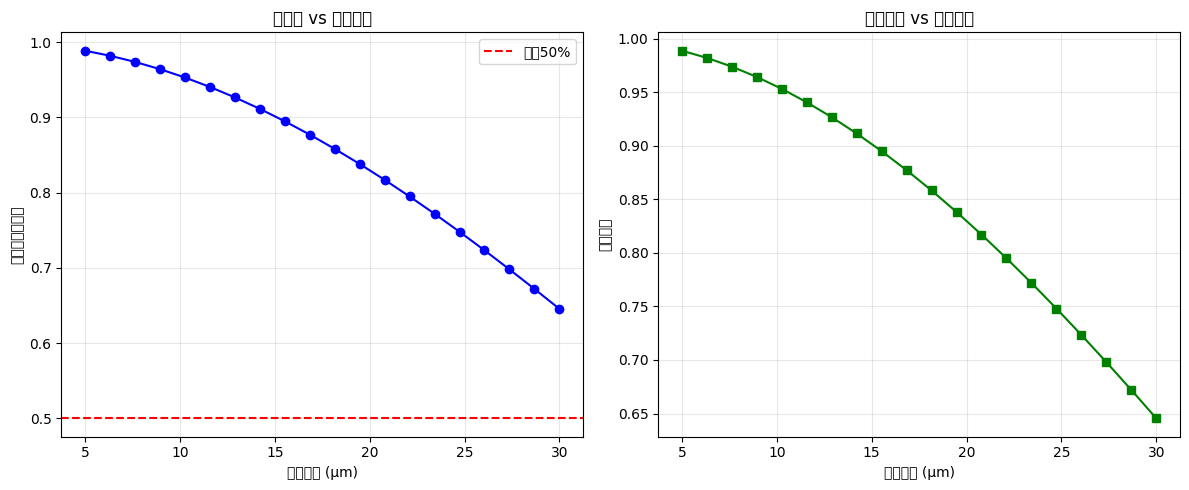

In [5]:
# 掃描耦合長度的影響
coupling_lengths = np.linspace(5, 30, 20)
splitting_ratios = []
transmissions = []

for length in coupling_lengths:
    test_params = DesignParameters(
        coupling_length=length,
        gap=0.2,
        waveguide_width=0.5,
        wavelength=1550e-9
    )
    
    test_result = simulator.simulate_classical(test_params)
    splitting_ratios.append(test_result.splitting_ratio[0])
    transmissions.append(test_result.transmission_efficiency)

# 繪圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(coupling_lengths, splitting_ratios, 'b-o')
ax1.axhline(y=0.5, color='r', linestyle='--', label='目標50%')
ax1.set_xlabel('耦合長度 (μm)')
ax1.set_ylabel('第一端口分束比')
ax1.set_title('分束比 vs 耦合長度')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(coupling_lengths, transmissions, 'g-s')
ax2.set_xlabel('耦合長度 (μm)')
ax2.set_ylabel('傳輸效率')
ax2.set_title('傳輸效率 vs 耦合長度')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 快速最佳化示例

In [6]:
# 定義目標函數
def optimize_splitter(params):
    design_params = DesignParameters(
        coupling_length=params['coupling_length'],
        gap=params['gap'],
        waveguide_width=params['waveguide_width'],
        wavelength=1550e-9
    )
    
    result = simulator.simulate_classical(design_params)
    evaluation = quick_evaluate(result, target_splitting_ratio=[0.5, 0.5])
    
    return evaluation['composite_score']

# 定義搜尋範圍
bounds = {
    'coupling_length': (8.0, 25.0),
    'gap': (0.15, 0.4),
    'waveguide_width': (0.4, 0.6)
}

# 執行貝葉斯最佳化
print("執行快速最佳化（15次迭代）...")
best_params, best_value, history = optimize_design(
    optimize_splitter,
    bounds,
    n_iterations=15,
    verbose=True
)

print(f"\n最佳化完成！")
print(f"最佳評分: {best_value:.4f}")
print(f"最佳參數:")
for param, value in best_params.items():
    print(f"  {param}: {value:.4f}")

執行快速最佳化（15次迭代）...
Iteration 10/15, Best: 0.7908

=== 最佳化完成 ===
最佳目標值: 0.8421
最佳參數:
  coupling_length: 20.5581
  gap: 0.1500
  waveguide_width: 0.4000

最佳化完成！
最佳評分: 0.8421
最佳參數:
  coupling_length: 20.5581
  gap: 0.1500
  waveguide_width: 0.4000


## 7. 最佳設計的詳細分析

In [7]:
# 使用最佳參數進行詳細分析
optimal_params = DesignParameters(
    coupling_length=best_params['coupling_length'],
    gap=best_params['gap'],
    waveguide_width=best_params['waveguide_width'],
    wavelength=1550e-9
)

optimal_result = simulator.simulate_classical(optimal_params)
optimal_evaluation = quick_evaluate(optimal_result, target_splitting_ratio=[0.5, 0.5])

print("=== 最佳設計詳細分析 ===")
print(f"設計參數:")
print(f"  耦合長度: {optimal_params.coupling_length:.3f} μm")
print(f"  間距: {optimal_params.gap:.3f} μm")
print(f"  波導寬度: {optimal_params.waveguide_width:.3f} μm")

print(f"\n性能指標:")
print(f"  分束比: {optimal_result.splitting_ratio[0]:.4f} / {optimal_result.splitting_ratio[1]:.4f}")
print(f"  50/50偏差: {abs(optimal_result.splitting_ratio[0] - 0.5):.4f}")
print(f"  插入損耗: {optimal_result.loss_db:.3f} dB")
print(f"  保真度: {optimal_result.fidelity:.4f}")
print(f"  製程容忍度: {optimal_result.robustness_score:.4f}")
print(f"  綜合評分: {optimal_evaluation['composite_score']:.4f}")

=== 最佳設計詳細分析 ===
設計參數:
  耦合長度: 20.558 μm
  間距: 0.150 μm
  波導寬度: 0.400 μm

性能指標:
  分束比: 0.5647 / 0.4353
  50/50偏差: 0.0647
  插入損耗: -0.000 dB
  保真度: 0.9958
  製程容忍度: 0.9896
  綜合評分: 0.8419


## 8. 最佳化收斂分析

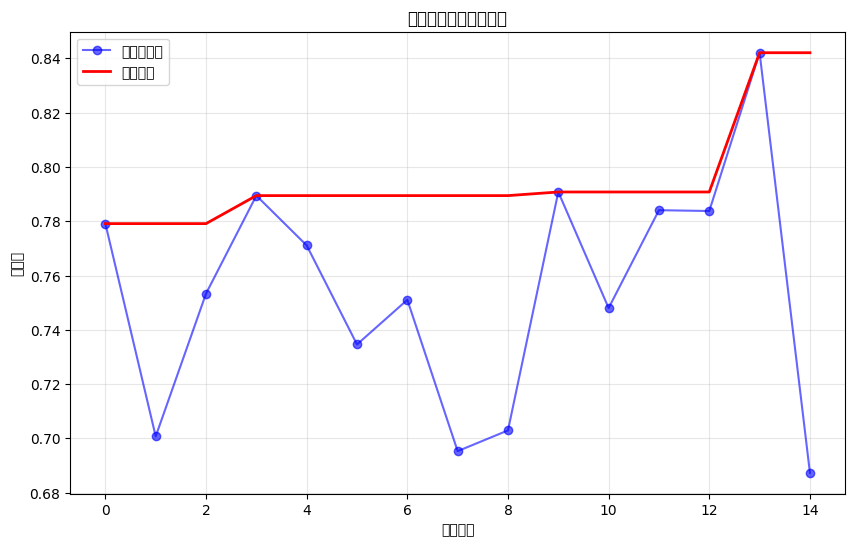

最佳化改善: 0.0630
收斂率: 20.00%


In [8]:
# 繪製最佳化收斂歷史
iterations = [h['iteration'] for h in history]
objectives = [h['objective'] for h in history]
best_so_far = [max(objectives[:i+1]) for i in range(len(objectives))]

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, 'b-o', alpha=0.6, label='當前目標值')
plt.plot(iterations, best_so_far, 'r-', linewidth=2, label='目前最佳')
plt.xlabel('迭代次數')
plt.ylabel('目標值')
plt.title('貝葉斯最佳化收斂歷史')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"最佳化改善: {best_so_far[-1] - best_so_far[0]:.4f}")
print(f"收斂率: {len([i for i, x in enumerate(best_so_far[1:], 1) if x > best_so_far[i-1]]) / len(best_so_far):.2%}")

## 9. 小結

這個演示筆記本展示了AI輔助矽光子量子電路設計平台的基本功能：

1. **元件建模**: 使用物理模型模擬矽光子元件
2. **電路模擬**: 組合元件形成完整電路並進行模擬
3. **性能評估**: 多維度評估設計性能
4. **智能最佳化**: 使用貝葉斯最佳化自動尋找最佳設計
5. **結果分析**: 可視化和分析最佳化結果

這個平台可以幫助設計師快速探索設計空間，找到滿足特定需求的最佳矽光子量子電路設計。